In [1]:
import pandas as pd
import numpy as np, os
import matplotlib.pyplot as plt

from pathlib import Path

from vivarium import Artifact


!date
!whoami
!pwd

Wed Oct 29 07:40:36 PDT 2025
tylerdy
/mnt/share/homes/tylerdy/vivarium_research_alzheimers/verification_and_validation


In [2]:
age_mapping = pd.read_csv(f"../age_bins.csv")  # downloaded with a different environment
# using vivarium_inputs.utility_data.get_age_bins;
# see also https://shiny.ihme.washington.edu/content/273/
# TODO: refactor this so that it does not require an extra .csv file
age_mapping

,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,5,5,0 to 5,0.0,5.0
1,6,6,5 to 9,5.0,10.0
2,7,7,10 to 14,10.0,15.0
3,8,8,15 to 19,15.0,20.0
4,9,9,20 to 24,20.0,25.0
5,10,10,25 to 29,25.0,30.0
6,11,11,30 to 34,30.0,35.0
7,12,12,35 to 39,35.0,40.0
8,13,13,40 to 44,40.0,45.0
9,14,14,45 to 49,45.0,50.0


## V&V List from Docs 

    - Verify that all simulants in the model have AD (i.e., all recorded person-time is in one of the “AD” states, not the “susceptible” state)
    - Verify that there are simulant person-years of BBBM-AD, MCI-AD, and AD-dementia for every year and age group of simulation
    - Verify that there are transitions between AD states are at the expected rates
    - Verify other sim mortality against artifact (ACMR - CSMR)
    - Verify Alzheimer’s EMR against artifact
    - Verify the number of new AD-demential cases per year against the AD population model

# Load Data

In [4]:
# %cd /mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/

In [3]:
locations = [
    "united_states_of_america",
    #              'china',
    #              'brazil',
    #              'japan',
    #             'sweden',
    #              'united_kingdom',
]


results_dirs = [
    "/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/results/abie_consistent_model_test/united_states_of_america/2025_10_27_14_30_10/results/"
]

artifact_dirs = [
    "/mnt/share/homes/abie/projects/2025/vivarium_csu_alzheimers/united_states_of_america.hdf"
]
artifact_dirs

['/mnt/share/homes/abie/projects/2025/vivarium_csu_alzheimers/united_states_of_america.hdf']

In [4]:
[x for x in os.listdir(results_dirs[0]) if "parquet" in x]

['counts_newly_eligible_for_bbbm_testing.parquet',
 'deaths.parquet',
 'counts_new_simulants.parquet',
 'ylls.parquet',
 'person_time_eligible_for_bbbm_testing.parquet',
 'transition_count_alzheimers_disease_and_other_dementias.parquet',
 'transition_count_treatment.parquet',
 'ylds.parquet',
 'counts_bbbm_tests.parquet',
 'person_time_treatment.parquet',
 'person_time_alzheimers_disease_and_other_dementias.parquet',
 'person_time_ever_eligible_for_bbbm_testing.parquet',
 'counts_baseline_tests_among_eligible.parquet']

In [5]:
# age_group_ids = [11,12,13,14,15,16,17,18,19,20,30,31,32,33]
# art = Artifact(artifact_dirs[0],
#                filter_terms = ['year_start==2021']  # FIXME: make this work even without filter_terms
#               )

# age_dictionary = pd.DataFrame()
# age_dictionary['age_group_id'] = age_group_ids
# age_dictionary = age_dictionary.merge(get_ids('age_group'), on='age_group_id')
# age_dictionary['age_group'] = age_dictionary.age_group_name.str.lower().str.replace(' ', '_')
# artifact = art.load('population.structure').reset_index()
# artifact = artifact.loc[artifact.age_start > 29].reset_index()
# age_dictionary['age_start'] = artifact.age_start
# age_dictionary['age_end'] = artifact.age_end

# # tweak final row to be named age group 95_plus
# assert age_dictionary.loc[13, 'age_group'] == '95_to_99'
# age_dictionary.loc[13, 'age_group'] = '95_plus'

# age_dictionary.tail()

age_dictionary = age_mapping.copy()
age_dictionary["age_group"] = age_dictionary.age_group_name.str.lower().str.replace(
    " ", "_"
)
age_dictionary

,Unnamed: 0,age_group_id,age_group_name,age_start,age_end,age_group
0,5,5,0 to 5,0.0,5.0,0_to_5
1,6,6,5 to 9,5.0,10.0,5_to_9
2,7,7,10 to 14,10.0,15.0,10_to_14
3,8,8,15 to 19,15.0,20.0,15_to_19
4,9,9,20 to 24,20.0,25.0,20_to_24
5,10,10,25 to 29,25.0,30.0,25_to_29
6,11,11,30 to 34,30.0,35.0,30_to_34
7,12,12,35 to 39,35.0,40.0,35_to_39
8,13,13,40 to 44,40.0,45.0,40_to_44
9,14,14,45 to 49,45.0,50.0,45_to_49


In [6]:
age_group_ids = age_dictionary.query(
    "age_start >= 30 and age_start <= 95"
).age_group_id.values

## Verify that all simulants in the model have AD 

In [7]:
def load_df(measure):
    data = pd.DataFrame()
    #     import pdb; pdb.set_trace()
    for results_dir in results_dirs:
        temp = pd.read_parquet(
            results_dir + measure + ".parquet",
            #                                filters=[('artifact_path', '==', '/mnt/team/simulation_science/pub/models/vivarium_csu_alzheimers/artifacts/model7.0/united_states_of_america.hdf')],
            #                                nrows=1000
        )
        display(temp)
        # just look at the baseline scenario for v&v purposes
        temp = temp[temp.scenario == "baseline"]

        # aggregate by summing value column over random seeds
        #         print(temp.columns)
        #         import pdb; pdb.set_trace()
        cols = [
            c
            for c in temp.columns
            if c not in ["value", "random_seed", "treatment", "artifact_path"]
        ]
        temp = temp.groupby(cols)["value"].sum().reset_index()

        temp["location"] = locations[results_dirs.index(results_dir)].title()
        temp["event_year"] = temp["event_year"].astype(int)
        data = pd.concat([data, temp], ignore_index=True)
    return data

In [8]:
person_time = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29159995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.000000
29159996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.000000
29159997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,7.474333
29159998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.000000


/tmp/ipykernel_2410901/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,457,baseline,457,0.000000,United_States_Of_America
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Male,457,baseline,457,0.000000,United_States_Of_America
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2026,Female,457,baseline,457,0.000000,United_States_Of_America
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2026,Male,457,baseline,457,0.000000,United_States_Of_America
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2027,Female,457,baseline,457,0.000000,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...,...
3235,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2058,Male,457,baseline,457,43506.595483,United_States_Of_America
3236,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2059,Female,457,baseline,457,132297.681040,United_States_Of_America
3237,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2059,Male,457,baseline,457,43333.689254,United_States_Of_America
3238,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state,95_plus,2060,Female,457,baseline,457,132494.505133,United_States_Of_America


In [9]:
person_time.loc[
    person_time.sub_entity == "susceptible_to_alzheimers_disease_and_other_dementias"
].value.sum()

0.0

In [10]:
assert (
    person_time.loc[
        person_time.sub_entity
        == "susceptible_to_alzheimers_disease_and_other_dementias"
    ].value.sum()
    == 0
), "should be zero years of person-time susceptible"

# Verify that there *are* simulants in BBBM-AD and MCI-AD for all ages and years

In [11]:
person_time.groupby("sub_entity").value.sum()

/tmp/ipykernel_2410901/2876506740.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby("sub_entity").value.sum()


sub_entity
alzheimers_blood_based_biomarker_state        1.706072e+08
alzheimers_disease_state                      2.986549e+08
alzheimers_mild_cognitive_impairment_state    1.249423e+08
Name: value, dtype: float64

In [12]:
person_time.groupby(
    ["location", "event_year", "age_group", "sub_entity"]
).value.sum().unstack()

/tmp/ipykernel_2410901/1677760363.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby(


sub_entity                                     alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
United_States_Of_America 2025       25_to_29                             0.000000e+00   
                                    30_to_34                             7.234656e+03   
                                    35_to_39                             9.379291e+03   
                                    40_to_44                             6.455830e+03   
                                    45_to_49                             1.771018e+04   
...                                                                               ...   
                         2060       75_to_79                             1.005304e+06   
                                    80_to_84                             1.184869e+06   
                                    85_to_89                             9.531269e+05   
                                    90_to_94                             5.069202e+05   
                                    95_plus                              1.539538e+05   

sub_entity                                     alzheimers_disease_state  \
location                 event_year age_group                             
United_States_Of_America 2025       25_to_29               0.000000e+00   
                                    30_to_34               3.667406e+02   
                                    35_to_39               1.565125e+03   
                                    40_to_44               5.931132e+03   
                                    45_to_49               3.526888e+03   
...                                                                 ...   
                         2060       75_to_79               1.739315e+06   
                                    80_to_84               2.236181e+06   
                                    85_to_89               1.991183e+06   
                                    90_to_94               1.140724e+06   
                                    95_plus                4.522973e+05   

sub_entity                                     alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
United_States_Of_America 2025       25_to_29                                     0.000000  
                                    30_to_34                                  5977.472964  
                                    35_to_39                                  3319.600274  
                                    40_to_44                                  3830.346338  
                                    45_to_49                                  5834.962355  
...                                                                                   ...  
                         2060       75_to_79                                661103.726215  
                                    80_to_84                                864638.773443  
                                    85_to_89                                800413.826146  
                                    90_to_94                                482125.848049  
                                    95_plus                                 175431.556468  

[540 rows x 3 columns]

In [15]:
# assert np.all(person_time[~person_time.age_group.isin(['25_to_29', '30_to_34', '35_to_40'])
#                          ].groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack().fillna(0) > 0)

## Verify that there are no transitions out of susceptible state during the simulation 

In [13]:
trans = load_df("transition_count_alzheimers_disease_and_other_dementias")
trans.loc[
    trans.sub_entity
    == "susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias"
].value.sum()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
1,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
2,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
3,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
4,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19439995,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0
19439996,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0
19439997,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,2.0
19439998,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0


/tmp/ipykernel_2410901/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


0.0

In [17]:
# assert trans.loc[trans.sub_entity == 'susceptible_to_alzheimers_disease_and_other_dementias_to_alzheimers_disease_and_other_dementias'].value.sum() == 0, \
#        'should be zero transitions from susceptible to with-condition'

# And that there *are* transitions out of other states for all ages

In [18]:
# assert np.all(trans.groupby(['location', 'event_year', 'age_group', 'sub_entity']).value.sum().unstack() > 0)

## Next look at the transition rates and approximate durations for BBBM and MCI

In [14]:
out_counts = (
    trans.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)
out_counts.columns = [c.split("_to_")[0] for c in out_counts.columns]
out_counts

/tmp/ipykernel_2410901/3292819502.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trans.groupby(["location", "event_year", "age_group", "sub_entity"])


alzheimers_blood_based_biomarker_state  \
location                 event_year age_group                                           
United_States_Of_America 2025       25_to_29                                      0.0   
                                    30_to_34                                   1108.0   
                                    35_to_39                                   1432.0   
                                    40_to_44                                    879.0   
                                    45_to_49                                   2574.0   
...                                                                               ...   
                         2060       75_to_79                                 146421.0   
                                    80_to_84                                 176926.0   
                                    85_to_89                                 144104.0   
                                    90_to_94                                  75416.0   
                                    95_plus                                   23310.0   

                                               alzheimers_mild_cognitive_impairment_state  
location                 event_year age_group                                              
United_States_Of_America 2025       25_to_29                                          0.0  
                                    30_to_34                                       1555.0  
                                    35_to_39                                        860.0  
                                    40_to_44                                        942.0  
                                    45_to_49                                       1489.0  
...                                                                                   ...  
                         2060       75_to_79                                     169909.0  
                                    80_to_84                                     218647.0  
                                    85_to_89                                     199879.0  
                                    90_to_94                                     115639.0  
                                    95_plus                                       39593.0  

[540 rows x 2 columns]

In [15]:
out_rates = (
    out_counts
    / person_time.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)
out_rates["alzheimers_blood_based_biomarker_state"].unstack()

/tmp/ipykernel_2410901/2654564655.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  / person_time.groupby(["location", "event_year", "age_group", "sub_entity"])


age_group                            25_to_29  30_to_34  35_to_39  40_to_44  \
location                 event_year                                           
United_States_Of_America 2025             NaN  0.153152  0.152677  0.136156   
                         2026             NaN  0.165213  0.167473  0.138212   
                         2027             NaN  0.168156  0.168132  0.139489   
                         2028             NaN  0.182888  0.184522  0.143673   
                         2029             NaN  0.179836  0.185044  0.149938   
                         2030             NaN  0.334478  0.182164  0.140772   
                         2031             NaN  0.000000  0.192567  0.141368   
                         2032             NaN  0.000000  0.204701  0.143869   
                         2033             NaN  0.501717  0.197579  0.143028   
                         2034             NaN  0.000000  0.169698  0.136359   
                         2035             NaN       NaN  0.000000  0.137751   
                         2036             NaN       NaN  0.000000  0.131590   
                         2037             NaN       NaN  1.003434  0.129355   
                         2038             NaN  0.000000  0.000000  0.134433   
                         2039             NaN  0.000000  0.000000  0.124161   
                         2040             NaN  0.000000  0.000000  0.120458   
                         2041             NaN  0.000000  0.401374  0.132228   
                         2042             NaN  0.401374  0.000000  0.130539   
                         2043             NaN  0.000000  0.000000  0.127908   
                         2044             NaN  0.286695  0.000000  0.131243   
                         2045             NaN  0.000000  0.000000  0.128472   
                         2046             NaN  0.000000  0.182443  0.127560   
                         2047             NaN  0.000000  0.000000  0.123971   
                         2048             NaN  0.668956  0.000000  0.120811   
                         2049             NaN  0.668956  0.167239  0.125794   
                         2050             NaN       NaN  0.000000  0.125417   
                         2051             NaN  0.000000  0.000000  0.128439   
                         2052             NaN  0.000000  0.000000  0.127518   
                         2053             NaN  0.000000  1.003434  0.127716   
                         2054             NaN  0.000000  0.668956  0.124253   
                         2055             NaN       NaN  0.000000  0.126770   
                         2056             NaN  0.000000  0.401374  0.128299   
                         2057             NaN  0.000000  0.000000  0.125559   
                         2058             NaN       NaN  0.286695  0.126066   
                         2059             NaN       NaN  0.000000  0.124401   
                         2060             NaN  0.000000  0.000000  0.122181   

age_group                            45_to_49  50_to_54  55_to_59  60_to_64  \
location                 event_year                                           
United_States_Of_America 2025        0.145340  0.144730  0.146799  0.146050   
                         2026        0.139351  0.147472  0.145285  0.144948   
                         2027        0.145848  0.146296  0.144736  0.145993   
                         2028        0.149201  0.147897  0.143804  0.145739   
                         2029        0.136263  0.148617  0.146359  0.143541   
                         2030        0.141561  0.149965  0.141538  0.144197   
                         2031        0.146352  0.146632  0.144576  0.142233   
                         2032        0.148330  0.152811  0.141723  0.143485   
                         2033        0.147865  0.145913  0.143655  0.141290   
                         2034        0.153593  0.150545  0.144608  0.142657   
                         2035        0.151388  0.

In [16]:
1 / 3.85

0.2597402597402597

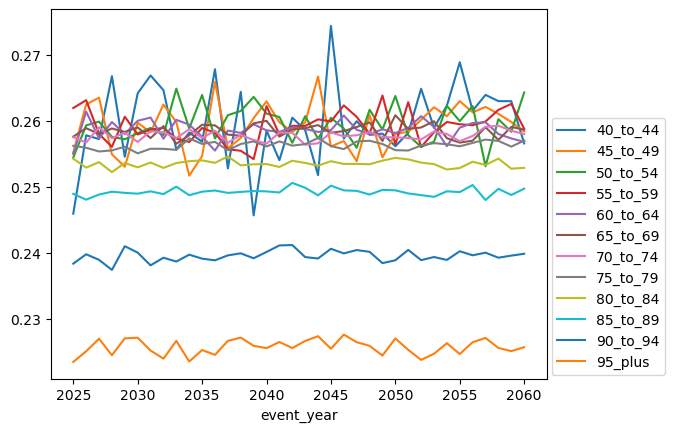

In [17]:
t = out_rates["alzheimers_mild_cognitive_impairment_state"].unstack()
t.loc["United_States_Of_America"].iloc[:, 3:].plot()
plt.legend(loc=(1.01, 0.01))

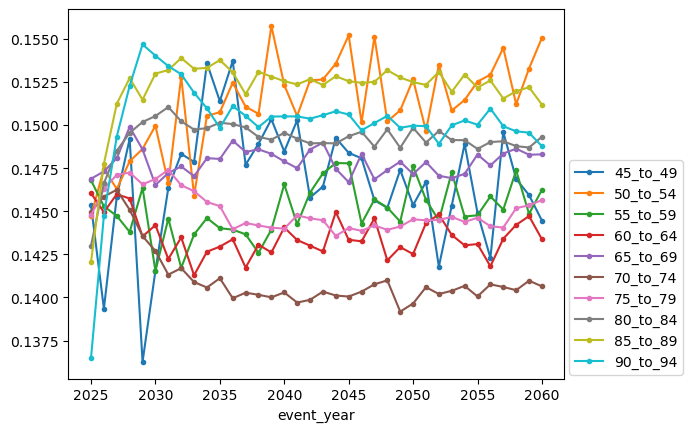

In [18]:
t = out_rates["alzheimers_blood_based_biomarker_state"].unstack()
t.loc["United_States_Of_America"].iloc[:, 4:14].plot(marker=".")
plt.legend(loc=(1.01, 0.01))

In [19]:
# prevalence \approx incidence * duration
prevalence_count = (
    person_time.groupby(["location", "event_year", "age_group", "sub_entity"])
    .value.sum()
    .unstack()
)

mci_duration_est = (
    prevalence_count["alzheimers_mild_cognitive_impairment_state"]
    / out_counts["alzheimers_blood_based_biomarker_state"]
)
mci_duration_est

/tmp/ipykernel_2410901/2467993286.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time.groupby(["location", "event_year", "age_group", "sub_entity"])


location                  event_year  age_group
United_States_Of_America  2025        25_to_29          NaN
                                      30_to_34     5.394831
                                      35_to_39     2.318157
                                      40_to_44     4.357618
                                      45_to_49     2.266885
                                                     ...   
                          2060        75_to_79     4.515088
                                      80_to_84     4.887008
                                      85_to_89     5.554418
                                      90_to_94     6.392885
                                      95_plus      7.526021
Length: 540, dtype: float64

In [20]:
new_sims = (
    load_df("counts_new_simulants")
    .groupby(
        [
            "location",
            "event_year",
            "age_group",
        ]
    )
    .value.sum()
)
# new_sims


bbbm_duration_est = (
    prevalence_count["alzheimers_blood_based_biomarker_state"] / new_sims
)
bbbm_duration_est

,age_group,event_year,sex,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
1,25_to_29,2025,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
2,25_to_29,2026,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
3,25_to_29,2026,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
4,25_to_29,2027,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
...,...,...,...,...,...,...,...,...,...
1079995,95_plus,2058,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0
1079996,95_plus,2059,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0
1079997,95_plus,2059,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0
1079998,95_plus,2060,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0


/tmp/ipykernel_2410901/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_2410901/2545667442.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(


location                  event_year  age_group
United_States_Of_America  2025        25_to_29             NaN
                                      30_to_34             inf
                                      35_to_39     4689.645448
                                      40_to_44        0.522443
                                      45_to_49        2.499320
                                                      ...     
                          2060        75_to_79        2.140743
                                      80_to_84        2.408451
                                      85_to_89        2.884566
                                      90_to_94        3.100885
                                      95_plus              inf
Length: 540, dtype: float64

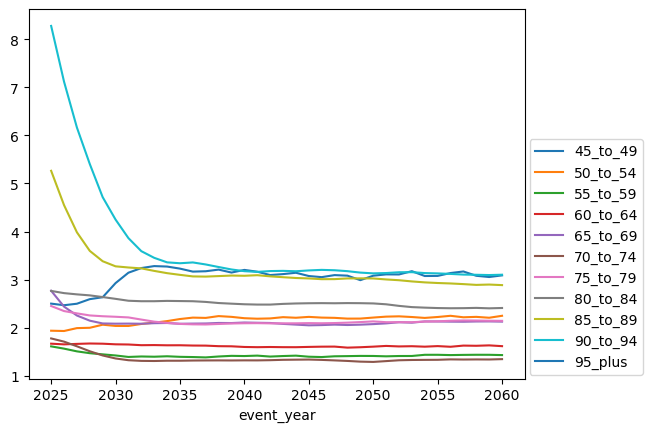

In [21]:
t = bbbm_duration_est.unstack()
t.loc["United_States_Of_America"].iloc[:, 4:].plot()
plt.legend(loc=(1.01, 00.01))

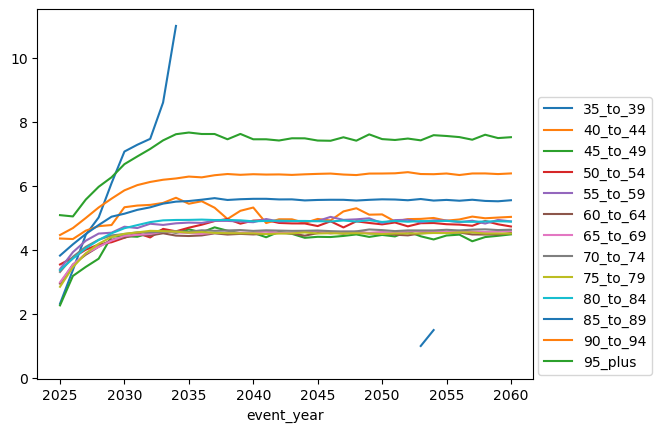

In [22]:
t = mci_duration_est.unstack()
t.loc["United_States_Of_America"].iloc[:, 2:].plot()
plt.legend(loc=(1.01, 0.01))

## Verify Other Cause Mortality in  Sim against artifact (ACMR - CSMR)

In [23]:
%%time

cols = ['input_draw','event_year','location','age_group','sex']

def calculate_ocmr():
    person_time_total = load_df('person_time_alzheimers_disease_and_other_dementias')
    total_pt = person_time_total.groupby(cols).sum(numeric_only=True)

    deaths = load_df('deaths')
    other_deaths = deaths[deaths.sub_entity == 'other_causes'].groupby(cols).sum(numeric_only=True)

    ocmr = (other_deaths / total_pt)[['value']].reset_index()

    ocmr2 = ocmr.merge(age_dictionary, on=['age_group'])
    ocmr3 = ocmr2.loc[ocmr2['age_group_id']#.isin(age_group_ids)
                     ]
    ocmr4 = ocmr2.groupby([c for c in cols if c != 'input_draw'] + ['age_start']).describe(percentiles=[0.025,0.975])['value'].reset_index()
    return ocmr4

sim_ocmr = calculate_ocmr()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29159995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.000000
29159996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.000000
29159997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,7.474333
29159998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.000000


/tmp/ipykernel_2410901/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
<timed exec>:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
1,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
2,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2026,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
3,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2026,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
4,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2027,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159995,deaths,cause,other_causes,other_causes,95_plus,2058,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,108.0
2159996,deaths,cause,other_causes,other_causes,95_plus,2059,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,270.0
2159997,deaths,cause,other_causes,other_causes,95_plus,2059,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,116.0
2159998,deaths,cause,other_causes,other_causes,95_plus,2060,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,282.0


/tmp/ipykernel_2410901/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
<timed exec>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<timed exec>:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


CPU times: user 25.5 s, sys: 6.21 s, total: 31.7 s
Wall time: 18.9 s


In [24]:
art_ocmr = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)

    # TODO: consider better ways to broadcast years from excess mx
    a = art.load(f"cause.all_causes.cause_specific_mortality_rate")
    b = art.load(
        f"cause.alzheimers_disease_and_other_dementias.cause_specific_mortality_rate"
    )

    data1 = (a - b.droplevel(["year_start", "year_end"])).dropna()
    data2 = (
        data1.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
        .filter(["mean", "2.5%", "97.5%"])
        .reset_index()
    )
    data3 = data2.merge(age_dictionary, on=["age_start", "age_end"])
    data4 = data3  # .loc[data3['age_group_id'].isin(age_group_ids)]
    data4["measure"] = "acmr"
    data4["location"] = locations[artifact_dirs.index(artifact_dir)].title()
    art_ocmr = pd.concat([art_ocmr, data4])
art_ocmr

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,Unnamed: 0,age_group_id,age_group_name,age_group,measure,location
0,Female,30.0,35.0,2022,2023,0.000931,0.000911,0.000951,11,11,30 to 34,30_to_34,acmr,United_States_Of_America
1,Female,30.0,35.0,2023,2024,0.000898,0.000875,0.000925,11,11,30 to 34,30_to_34,acmr,United_States_Of_America
2,Female,30.0,35.0,2024,2025,0.000900,0.000871,0.000935,11,11,30 to 34,30_to_34,acmr,United_States_Of_America
3,Female,30.0,35.0,2025,2026,0.000901,0.000865,0.000942,11,11,30 to 34,30_to_34,acmr,United_States_Of_America
4,Female,30.0,35.0,2026,2027,0.000902,0.000856,0.000950,11,11,30 to 34,30_to_34,acmr,United_States_Of_America
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,Male,90.0,95.0,2046,2047,0.187523,0.170802,0.206213,23,32,90 to 94,90_to_94,acmr,United_States_Of_America
750,Male,90.0,95.0,2047,2048,0.187622,0.170281,0.207026,23,32,90 to 94,90_to_94,acmr,United_States_Of_America
751,Male,90.0,95.0,2048,2049,0.187787,0.170087,0.207539,23,32,90 to 94,90_to_94,acmr,United_States_Of_America
752,Male,90.0,95.0,2049,2050,0.187738,0.169172,0.208122,23,32,90 to 94,90_to_94,acmr,United_States_Of_America


In [25]:
art_data = art_ocmr
location = "United_States_Of_America"
sex = "Female"
year = 2030
# art_data.loc[(art_data.location == location) & (art_data.sex == sex) & (art_data.year_start == year)]

In [26]:
def age_group_plot(measure, sim_data, art_data, art_year=None):
    for location in sim_data.location.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True)
        for i, year in enumerate([2030, 2040, 2050]):
            for j, sex in enumerate(sim_data.sex.unique()):
                color = f"C{j}"
                plot_data = sim_data.loc[
                    (sim_data.location == location)
                    & (sim_data.event_year == year)
                    & (sim_data.sex == sex)
                ]
                if art_year is None:
                    art_plot = art_data.loc[
                        (art_data.location == location)
                        & (art_data.sex == sex)
                        & (art_data.year_start == year)
                    ]
                else:
                    art_plot = art_data.loc[
                        (art_data.location == location)
                        & (art_data.sex == sex)
                        & (art_data.year_start == art_year)
                    ]

                ax[i].fill_between(
                    plot_data.age_start,
                    plot_data["2.5%"],
                    plot_data["97.5%"],
                    alpha=0.2,
                    color=color,
                )
                ax[i].fill_between(
                    art_plot.age_start,
                    art_plot["2.5%"],
                    art_plot["97.5%"],
                    alpha=0.2,
                    color=color,
                )

                ax[i].plot(
                    art_plot.age_start,
                    art_plot["mean"],
                    linestyle="--",
                    label=f"Artifact {sex}",
                    color=color,
                    linewidth=3,
                )
                ax[i].plot(
                    plot_data.age_start,
                    plot_data["mean"],
                    label=f"Simulation {sex}",
                    color=color,
                )

                if i == 0:
                    ax[i].set_title(f"{measure} in {location}")

                ax[i].text(
                    0.5,
                    0.95,
                    f"{year}",
                    va="top",
                    ha="center",
                    transform=ax[i].transAxes,
                )
                #                 ax[i].tick_params(axis='x', labelrotation=90)

                if i == 2:
                    ax[i].set_xlabel("Age Group")

                if i == 1:
                    ax[i].set_ylabel(f"{measure}")
                    ax[i].legend(loc=(1.01, 0))
        #                 ax[i].semilogy()
        plt.subplots_adjust(hspace=0)

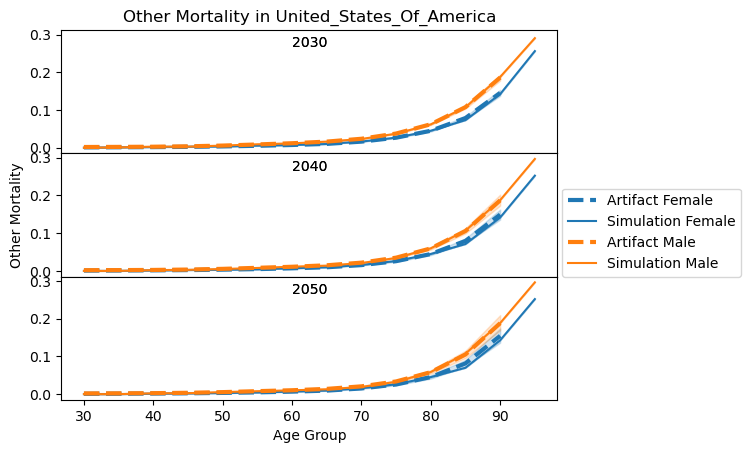

In [27]:
age_group_plot("Other Mortality", sim_ocmr, art_ocmr)

In [28]:
def over_time_plot(measure, sim_data, age_start):
    for location in sim_data.location.unique():
        for sex in sim_data.sex.unique():
            plot_data = sim_data.loc[
                (sim_data.location == location)
                & (sim_data.age_start == age_start)
                & (sim_data.sex == sex)
            ]

            plt.plot(plot_data.event_year, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.title(
                f"{measure} in {location} Over Time Among Age Start Group {age_start}"
            )
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Year")
            plt.ylabel(f"{measure}")
            plt.legend()
        plt.figure()

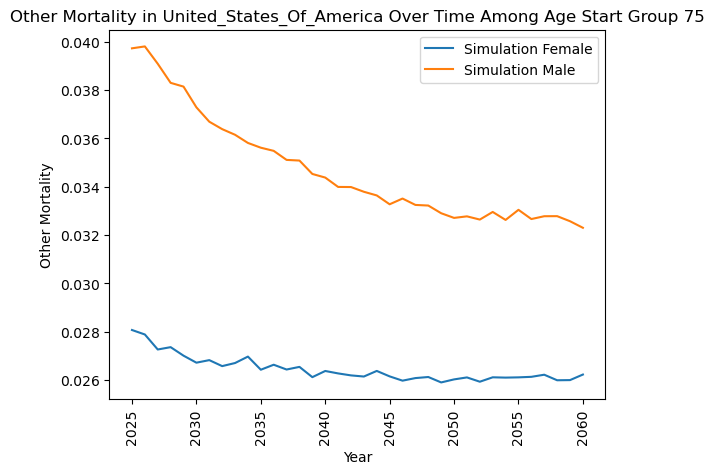

<Figure size 640x480 with 0 Axes>

In [29]:
over_time_plot("Other Mortality", sim_ocmr, 75)

## Validate Alzheimer’s EMR against GBD

In [30]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]


def calculate_emr():
    person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
    infected = (
        person_time_total.loc[
            person_time_total.sub_entity == "alzheimers_disease_state"
        ]
        .groupby(cols)
        .sum(numeric_only=True)
    )
    assert len(infected) > 0

    deaths0 = load_df("deaths")
    deaths = (
        deaths0.loc[deaths0.sub_entity == "alzheimers_disease_state"]
        .groupby(cols)
        .sum(numeric_only=True)
    )
    assert len(deaths) > 0

    mr = (deaths / infected)[["value"]].reset_index()

    mr = mr.merge(age_dictionary, on=["age_group"])
    mr = mr.loc[mr["age_group_id"].isin(age_group_ids)]
    mr1 = (
        mr.groupby([c for c in cols if c != "input_draw"] + ["age_start"])
        .describe(percentiles=[0.025, 0.975])["value"]
        .reset_index()
    )
    return mr1


sim_emr = calculate_emr()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29159995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.000000
29159996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.000000
29159997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,7.474333
29159998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.000000


/tmp/ipykernel_2410901/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_2410901/1623663996.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cols)


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
1,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2025,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
2,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2026,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
3,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2026,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
4,deaths,cause,alzheimers_disease_state,alzheimers_disease_state,25_to_29,2027,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159995,deaths,cause,other_causes,other_causes,95_plus,2058,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,108.0
2159996,deaths,cause,other_causes,other_causes,95_plus,2059,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,270.0
2159997,deaths,cause,other_causes,other_causes,95_plus,2059,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,116.0
2159998,deaths,cause,other_causes,other_causes,95_plus,2060,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,282.0


/tmp/ipykernel_2410901/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_2410901/1623663996.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(cols)
/tmp/ipykernel_2410901/1623663996.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mr.groupby([c for c in cols if c != "input_draw"] + ["age_start"])


In [31]:
def load_artifact_cause_data(measure, cause="alzheimers_disease_and_other_dementias"):
    out = pd.DataFrame()
    for artifact_dir in artifact_dirs:
        art = Artifact(artifact_dir)  # , filter_terms=["year_start==2021"])
        # display(art.keys)
        key = f"cause.{cause}.{measure}"
        data = art.load(key)
        data = (
            data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1)
            .filter(["mean", "2.5%", "97.5%"])
            .reset_index()
        )
        data = data.merge(age_dictionary, on=["age_start", "age_end"])
        #         data = data.loc[data['age_group_id'].isin(age_group_ids)]
        data["measure"] = measure
        data["location"] = locations[artifact_dirs.index(artifact_dir)].title()
        out = pd.concat([out, data])
    return out

In [32]:
art_emr = load_artifact_cause_data("excess_mortality_rate", "alzheimers")
# art_emr

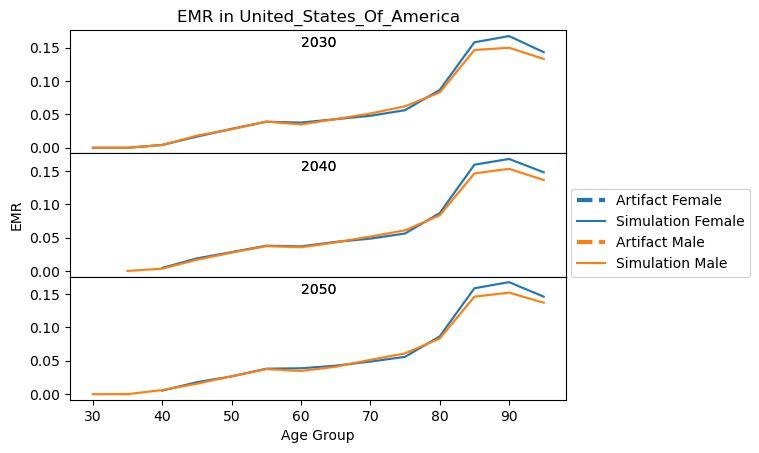

In [33]:
age_group_plot("EMR", sim_emr, art_emr, art_year=2021)

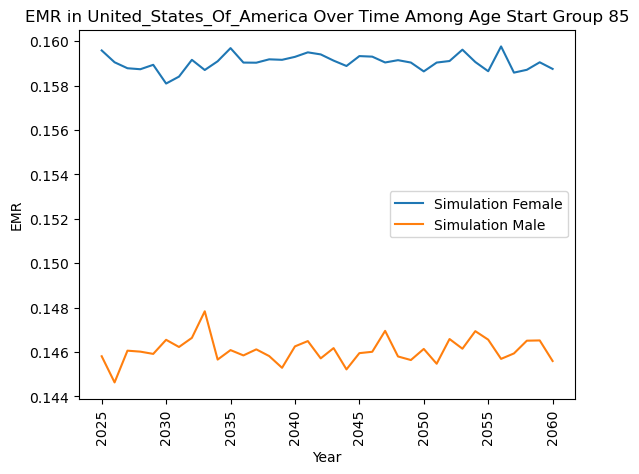

<Figure size 640x480 with 0 Axes>

In [34]:
over_time_plot("EMR", sim_emr, 85)

## Verify the number of new simulants per year against the AD population model

In [40]:
# art.keys

In [35]:
art_incidence_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("cause.alzheimers.population_incidence_rate").droplevel(
            ["year_start", "year_end"]
        ),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_incidence_data.append(df)

art_incidence_data = pd.concat(art_incidence_data)
for i in range(500):
    art_incidence_data[f"draw_{i}"] *= art_incidence_data[f"draw_{i}_pop"]
    del art_incidence_data[f"draw_{i}_pop"]

In [48]:
scale = pd.DataFrame()
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    temp = art.load("population.structure").reset_index()
    temp["location"] = temp.location.str.replace(" ", "_").str.title()
    #     import pdb; pdb.set_trace()
    df_prev_pop = pd.merge(
        art.load("population.scaling_factor").query("year_start == 2023"),
        art.load("population.structure")
        .query("year_start==2025")
        .droplevel(["year_start", "year_end"]),
        left_index=True,
        right_index=True,
        suffixes=["_prev", "_pop"],
    )
    prev = (
        (
            df_prev_pop.filter(like="draw_").filter(like="_prev")
            * df_prev_pop.filter(like="draw_").filter(like="_pop").values
        ).mean(axis=1)
    ).sum(axis=0)
    # TODO: use draw-specific scale instead of mean

    ratio = 100_000 / (prev + 0.01)
    temp["ratio"] = ratio

    temp = temp.rename(columns={"year_start": "event_year"})
    temp = temp.merge(age_dictionary, on=["age_start", "age_end"])
    temp = temp.loc[temp["age_group_id"].isin(age_group_ids)]
    scale = pd.concat([scale, temp], ignore_index=True)
display(prev)
scale

0.0

,location,sex,age_start,age_end,event_year,year_end,draw_0,draw_1,draw_2,draw_3,...,draw_495,draw_496,draw_497,draw_498,draw_499,ratio,Unnamed: 0,age_group_id,age_group_name,age_group
0,United_States_Of_America,Female,30.0,35.0,2021,2022,1.155513e+07,1.202714e+07,1.170002e+07,1.121486e+07,...,1.167054e+07,1.201985e+07,1.137727e+07,1.084559e+07,1.123404e+07,10000000.0,11,11,30 to 34,30_to_34
1,United_States_Of_America,Female,30.0,35.0,2022,2023,1.157185e+07,1.204003e+07,1.172012e+07,1.123139e+07,...,1.168870e+07,1.203246e+07,1.139530e+07,1.086539e+07,1.125544e+07,10000000.0,11,11,30 to 34,30_to_34
2,United_States_Of_America,Female,30.0,35.0,2023,2024,1.155799e+07,1.202068e+07,1.170977e+07,1.121918e+07,...,1.167535e+07,1.201230e+07,1.138381e+07,1.085858e+07,1.124764e+07,10000000.0,11,11,30 to 34,30_to_34
3,United_States_Of_America,Female,30.0,35.0,2024,2025,1.152694e+07,1.198565e+07,1.168434e+07,1.119215e+07,...,1.164489e+07,1.197490e+07,1.135707e+07,1.083734e+07,1.122622e+07,10000000.0,11,11,30 to 34,30_to_34
4,United_States_Of_America,Female,30.0,35.0,2025,2026,1.149575e+07,1.194940e+07,1.166062e+07,1.116640e+07,...,1.161536e+07,1.193850e+07,1.133165e+07,1.081614e+07,1.120671e+07,10000000.0,11,11,30 to 34,30_to_34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,United_States_Of_America,Male,95.0,125.0,2046,2047,4.776578e+05,5.406595e+05,5.049817e+05,5.222527e+05,...,5.227748e+05,5.281299e+05,6.701626e+05,5.409489e+05,5.437706e+05,10000000.0,24,235,95 plus,95_plus
836,United_States_Of_America,Male,95.0,125.0,2047,2048,4.897427e+05,5.562757e+05,5.190315e+05,5.397755e+05,...,5.386952e+05,5.446530e+05,6.986519e+05,5.599898e+05,5.617033e+05,10000000.0,24,235,95 plus,95_plus
837,United_States_Of_America,Male,95.0,125.0,2048,2049,5.022796e+05,5.729534e+05,5.336017e+05,5.583712e+05,...,5.547403e+05,5.616294e+05,7.281752e+05,5.794990e+05,5.800382e+05,10000000.0,24,235,95 plus,95_plus
838,United_States_Of_America,Male,95.0,125.0,2049,2050,5.147342e+05,5.894088e+05,5.479230e+05,5.767340e+05,...,5.703575e+05,5.778054e+05,7.574645e+05,5.992580e+05,5.981090e+05,10000000.0,24,235,95 plus,95_plus


In [37]:
scale.groupby(
    "location"
).ratio.describe() / 5  # compare to 0.0035494897066482814 in interactive sim for USA

,count,mean,std,min,25%,50%,75%,max
location,,,,,,,,
United_States_Of_America,168.0,2000000.0,0.0,2000000.0,2000000.0,2000000.0,2000000.0,2000000.0


In [38]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("counts_new_simulants")
new_sims

,age_group,event_year,sex,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,25_to_29,2025,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
1,25_to_29,2025,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
2,25_to_29,2026,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
3,25_to_29,2026,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
4,25_to_29,2027,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
...,...,...,...,...,...,...,...,...,...
1079995,95_plus,2058,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0
1079996,95_plus,2059,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0
1079997,95_plus,2059,Male,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0
1079998,95_plus,2060,Female,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0


/tmp/ipykernel_2410901/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location
0,25_to_29,2025,Female,457,baseline,457,0.0,United_States_Of_America
1,25_to_29,2025,Male,457,baseline,457,0.0,United_States_Of_America
2,25_to_29,2026,Female,457,baseline,457,0.0,United_States_Of_America
3,25_to_29,2026,Male,457,baseline,457,0.0,United_States_Of_America
4,25_to_29,2027,Female,457,baseline,457,0.0,United_States_Of_America
...,...,...,...,...,...,...,...,...
1075,95_plus,2058,Male,457,baseline,457,0.0,United_States_Of_America
1076,95_plus,2059,Female,457,baseline,457,0.0,United_States_Of_America
1077,95_plus,2059,Male,457,baseline,457,0.0,United_States_Of_America
1078,95_plus,2060,Female,457,baseline,457,0.0,United_States_Of_America


In [39]:
trans = load_df("transition_count_alzheimers_disease_and_other_dementias")
new_ad_dementia = trans[
    trans.sub_entity
    == "alzheimers_mild_cognitive_impairment_state_to_alzheimers_disease_state"
]

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
1,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
2,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
3,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
4,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state_to_alzh...,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,baseline,457,3167,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19439995,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0
19439996,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0
19439997,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,2.0
19439998,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,457,bbbm_testing_and_treatment,457,3528,0.0


/tmp/ipykernel_2410901/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


In [40]:
new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_ad_dementia = new_ad_dementia.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)

In [41]:
display(new_sims)
display(new_ad_dementia)

,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location,ratio
0,30_to_34,2025,Female,457,baseline,457,0.0,United_States_Of_America,10000000.0
1,30_to_34,2025,Male,457,baseline,457,0.0,United_States_Of_America,10000000.0
2,30_to_34,2026,Female,457,baseline,457,1.0,United_States_Of_America,10000000.0
3,30_to_34,2026,Male,457,baseline,457,0.0,United_States_Of_America,10000000.0
4,30_to_34,2027,Female,457,baseline,457,2.0,United_States_Of_America,10000000.0
...,...,...,...,...,...,...,...,...,...
723,95_plus,2048,Male,457,baseline,457,0.0,United_States_Of_America,10000000.0
724,95_plus,2049,Female,457,baseline,457,0.0,United_States_Of_America,10000000.0
725,95_plus,2049,Male,457,baseline,457,0.0,United_States_Of_America,10000000.0
726,95_plus,2050,Female,457,baseline,457,0.0,United_States_Of_America,10000000.0


,measure,entity_type,entity,sub_entity,age_group,event_year,sex,input_draw_number,scenario,input_draw,value,location,ratio
0,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Female,457,baseline,457,1066.0,United_States_Of_America,10000000.0
1,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2025,Male,457,baseline,457,489.0,United_States_Of_America,10000000.0
2,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2026,Female,457,baseline,457,812.0,United_States_Of_America,10000000.0
3,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2026,Male,457,baseline,457,323.0,United_States_Of_America,10000000.0
4,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,30_to_34,2027,Female,457,baseline,457,444.0,United_States_Of_America,10000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2048,Male,457,baseline,457,8189.0,United_States_Of_America,10000000.0
724,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2049,Female,457,baseline,457,26806.0,United_States_Of_America,10000000.0
725,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2049,Male,457,baseline,457,8538.0,United_States_Of_America,10000000.0
726,transition_count,cause,alzheimers_disease_and_other_dementias,alzheimers_mild_cognitive_impairment_state_to_...,95_plus,2050,Female,457,baseline,457,27674.0,United_States_Of_America,10000000.0


In [42]:
new_sims["total_incidence"] = new_sims["value"] / new_sims["ratio"]
new_ad_dementia["total_incidence"] = new_ad_dementia["value"] / new_sims["ratio"]


def summarize(df):
    df = df.groupby(cols).sum(numeric_only=True)
    df = (
        df.groupby([c for c in cols if c != "input_draw"])
        .describe(percentiles=[0.025, 0.975])["total_incidence"]
        .reset_index()
    )

    df = df.merge(age_dictionary, on=["age_group"])
    df = df.loc[df["age_group_id"].isin(age_group_ids)]

    return df


new_sims_summary = summarize(new_sims)
new_sims_summary

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,2025,United_States_Of_America,30_to_34,Female,1.0,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,11,11,30 to 34,30.0,35.0
1,2025,United_States_Of_America,30_to_34,Male,1.0,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,11,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,35_to_39,Female,1.0,1.000000e-07,NaN,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,12,12,35 to 39,35.0,40.0
3,2025,United_States_Of_America,35_to_39,Male,1.0,1.000000e-07,NaN,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,12,12,35 to 39,35.0,40.0
4,2025,United_States_Of_America,40_to_44,Female,1.0,8.307000e-04,NaN,8.307000e-04,8.307000e-04,8.307000e-04,8.307000e-04,8.307000e-04,13,13,40 to 44,40.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2050,United_States_Of_America,85_to_89,Male,1.0,1.363450e-02,NaN,1.363450e-02,1.363450e-02,1.363450e-02,1.363450e-02,1.363450e-02,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,1.0,1.225760e-02,NaN,1.225760e-02,1.225760e-02,1.225760e-02,1.225760e-02,1.225760e-02,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,1.0,4.126300e-03,NaN,4.126300e-03,4.126300e-03,4.126300e-03,4.126300e-03,4.126300e-03,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,1.0,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,24,235,95 plus,95.0,125.0


In [43]:
new_ad_dementia_summary = summarize(new_ad_dementia)
new_ad_dementia_summary

,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,2025,United_States_Of_America,30_to_34,Female,1.0,0.000107,NaN,0.000107,0.000107,0.000107,0.000107,0.000107,11,11,30 to 34,30.0,35.0
1,2025,United_States_Of_America,30_to_34,Male,1.0,0.000049,NaN,0.000049,0.000049,0.000049,0.000049,0.000049,11,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,35_to_39,Female,1.0,0.000056,NaN,0.000056,0.000056,0.000056,0.000056,0.000056,12,12,35 to 39,35.0,40.0
3,2025,United_States_Of_America,35_to_39,Male,1.0,0.000030,NaN,0.000030,0.000030,0.000030,0.000030,0.000030,12,12,35 to 39,35.0,40.0
4,2025,United_States_Of_America,40_to_44,Female,1.0,0.000066,NaN,0.000066,0.000066,0.000066,0.000066,0.000066,13,13,40 to 44,40.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
723,2050,United_States_Of_America,85_to_89,Male,1.0,0.006655,NaN,0.006655,0.006655,0.006655,0.006655,0.006655,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,1.0,0.008309,NaN,0.008309,0.008309,0.008309,0.008309,0.008309,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,1.0,0.003427,NaN,0.003427,0.003427,0.003427,0.003427,0.003427,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,1.0,0.002767,NaN,0.002767,0.002767,0.002767,0.002767,0.002767,24,235,95 plus,95.0,125.0


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
0,2025,United_States_Of_America,30_to_34,Female,1.0,0.000107,NaN,0.000107,0.000107,0.000107,0.000107,0.000107,11,11,30 to 34,30.0,35.0
2,2025,United_States_Of_America,35_to_39,Female,1.0,0.000056,NaN,0.000056,0.000056,0.000056,0.000056,0.000056,12,12,35 to 39,35.0,40.0
4,2025,United_States_Of_America,40_to_44,Female,1.0,0.000066,NaN,0.000066,0.000066,0.000066,0.000066,0.000066,13,13,40 to 44,40.0,45.0
6,2025,United_States_Of_America,45_to_49,Female,1.0,0.000101,NaN,0.000101,0.000101,0.000101,0.000101,0.000101,14,14,45 to 49,45.0,50.0
8,2025,United_States_Of_America,50_to_54,Female,1.0,0.000215,NaN,0.000215,0.000215,0.000215,0.000215,0.000215,15,15,50 to 54,50.0,55.0
10,2025,United_States_Of_America,55_to_59,Female,1.0,0.000564,NaN,0.000564,0.000564,0.000564,0.000564,0.000564,16,16,55 to 59,55.0,60.0
12,2025,United_States_Of_America,60_to_64,Female,1.0,0.001056,NaN,0.001056,0.001056,0.001056,0.001056,0.001056,17,17,60 to 64,60.0,65.0
14,2025,United_States_Of_America,65_to_69,Female,1.0,0.002525,NaN,0.002525,0.002525,0.002525,0.002525,0.002525,18,18,65 to 69,65.0,70.0
16,2025,United_States_Of_America,70_to_74,Female,1.0,0.006182,NaN,0.006182,0.006182,0.006182,0.006182,0.006182,19,19,70 to 74,70.0,75.0
18,2025,United_States_Of_America,75_to_79,Female,1.0,0.007367,NaN,0.007367,0.007367,0.007367,0.007367,0.007367,20,20,75 to 79,75.0,80.0


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
280,2035,United_States_Of_America,30_to_34,Female,1.0,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,11,11,30 to 34,30.0,35.0
282,2035,United_States_Of_America,35_to_39,Female,1.0,2.000000e-07,NaN,2.000000e-07,2.000000e-07,2.000000e-07,2.000000e-07,2.000000e-07,12,12,35 to 39,35.0,40.0
284,2035,United_States_Of_America,40_to_44,Female,1.0,1.419000e-04,NaN,1.419000e-04,1.419000e-04,1.419000e-04,1.419000e-04,1.419000e-04,13,13,40 to 44,40.0,45.0
286,2035,United_States_Of_America,45_to_49,Female,1.0,2.986000e-04,NaN,2.986000e-04,2.986000e-04,2.986000e-04,2.986000e-04,2.986000e-04,14,14,45 to 49,45.0,50.0
288,2035,United_States_Of_America,50_to_54,Female,1.0,3.861000e-04,NaN,3.861000e-04,3.861000e-04,3.861000e-04,3.861000e-04,3.861000e-04,15,15,50 to 54,50.0,55.0
290,2035,United_States_Of_America,55_to_59,Female,1.0,6.436000e-04,NaN,6.436000e-04,6.436000e-04,6.436000e-04,6.436000e-04,6.436000e-04,16,16,55 to 59,55.0,60.0
292,2035,United_States_Of_America,60_to_64,Female,1.0,1.349500e-03,NaN,1.349500e-03,1.349500e-03,1.349500e-03,1.349500e-03,1.349500e-03,17,17,60 to 64,60.0,65.0
294,2035,United_States_Of_America,65_to_69,Female,1.0,2.760900e-03,NaN,2.760900e-03,2.760900e-03,2.760900e-03,2.760900e-03,2.760900e-03,18,18,65 to 69,65.0,70.0
296,2035,United_States_Of_America,70_to_74,Female,1.0,6.793000e-03,NaN,6.793000e-03,6.793000e-03,6.793000e-03,6.793000e-03,6.793000e-03,19,19,70 to 74,70.0,75.0
298,2035,United_States_Of_America,75_to_79,Female,1.0,1.260660e-02,NaN,1.260660e-02,1.260660e-02,1.260660e-02,1.260660e-02,1.260660e-02,20,20,75 to 79,75.0,80.0


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
560,2045,United_States_Of_America,30_to_34,Female,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,11,11,30 to 34,30.0,35.0
562,2045,United_States_Of_America,35_to_39,Female,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,12,12,35 to 39,35.0,40.0
564,2045,United_States_Of_America,40_to_44,Female,1.0,0.000121,NaN,0.000121,0.000121,0.000121,0.000121,0.000121,13,13,40 to 44,40.0,45.0
566,2045,United_States_Of_America,45_to_49,Female,1.0,0.000265,NaN,0.000265,0.000265,0.000265,0.000265,0.000265,14,14,45 to 49,45.0,50.0
568,2045,United_States_Of_America,50_to_54,Female,1.0,0.000415,NaN,0.000415,0.000415,0.000415,0.000415,0.000415,15,15,50 to 54,50.0,55.0
570,2045,United_States_Of_America,55_to_59,Female,1.0,0.000741,NaN,0.000741,0.000741,0.000741,0.000741,0.000741,16,16,55 to 59,55.0,60.0
572,2045,United_States_Of_America,60_to_64,Female,1.0,0.001487,NaN,0.001487,0.001487,0.001487,0.001487,0.001487,17,17,60 to 64,60.0,65.0
574,2045,United_States_Of_America,65_to_69,Female,1.0,0.002642,NaN,0.002642,0.002642,0.002642,0.002642,0.002642,18,18,65 to 69,65.0,70.0
576,2045,United_States_Of_America,70_to_74,Female,1.0,0.006135,NaN,0.006135,0.006135,0.006135,0.006135,0.006135,19,19,70 to 74,70.0,75.0
578,2045,United_States_Of_America,75_to_79,Female,1.0,0.011786,NaN,0.011786,0.011786,0.011786,0.011786,0.011786,20,20,75 to 79,75.0,80.0


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
1,2025,United_States_Of_America,30_to_34,Male,1.0,0.000049,NaN,0.000049,0.000049,0.000049,0.000049,0.000049,11,11,30 to 34,30.0,35.0
3,2025,United_States_Of_America,35_to_39,Male,1.0,0.000030,NaN,0.000030,0.000030,0.000030,0.000030,0.000030,12,12,35 to 39,35.0,40.0
5,2025,United_States_Of_America,40_to_44,Male,1.0,0.000028,NaN,0.000028,0.000028,0.000028,0.000028,0.000028,13,13,40 to 44,40.0,45.0
7,2025,United_States_Of_America,45_to_49,Male,1.0,0.000048,NaN,0.000048,0.000048,0.000048,0.000048,0.000048,14,14,45 to 49,45.0,50.0
9,2025,United_States_Of_America,50_to_54,Male,1.0,0.000110,NaN,0.000110,0.000110,0.000110,0.000110,0.000110,15,15,50 to 54,50.0,55.0
11,2025,United_States_Of_America,55_to_59,Male,1.0,0.000289,NaN,0.000289,0.000289,0.000289,0.000289,0.000289,16,16,55 to 59,55.0,60.0
13,2025,United_States_Of_America,60_to_64,Male,1.0,0.000527,NaN,0.000527,0.000527,0.000527,0.000527,0.000527,17,17,60 to 64,60.0,65.0
15,2025,United_States_Of_America,65_to_69,Male,1.0,0.001215,NaN,0.001215,0.001215,0.001215,0.001215,0.001215,18,18,65 to 69,65.0,70.0
17,2025,United_States_Of_America,70_to_74,Male,1.0,0.002799,NaN,0.002799,0.002799,0.002799,0.002799,0.002799,19,19,70 to 74,70.0,75.0
19,2025,United_States_Of_America,75_to_79,Male,1.0,0.003504,NaN,0.003504,0.003504,0.003504,0.003504,0.003504,20,20,75 to 79,75.0,80.0


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
281,2035,United_States_Of_America,30_to_34,Male,1.0,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,11,11,30 to 34,30.0,35.0
283,2035,United_States_Of_America,35_to_39,Male,1.0,2.000000e-07,NaN,2.000000e-07,2.000000e-07,2.000000e-07,2.000000e-07,2.000000e-07,12,12,35 to 39,35.0,40.0
285,2035,United_States_Of_America,40_to_44,Male,1.0,6.830000e-05,NaN,6.830000e-05,6.830000e-05,6.830000e-05,6.830000e-05,6.830000e-05,13,13,40 to 44,40.0,45.0
287,2035,United_States_Of_America,45_to_49,Male,1.0,1.519000e-04,NaN,1.519000e-04,1.519000e-04,1.519000e-04,1.519000e-04,1.519000e-04,14,14,45 to 49,45.0,50.0
289,2035,United_States_Of_America,50_to_54,Male,1.0,1.896000e-04,NaN,1.896000e-04,1.896000e-04,1.896000e-04,1.896000e-04,1.896000e-04,15,15,50 to 54,50.0,55.0
291,2035,United_States_Of_America,55_to_59,Male,1.0,3.387000e-04,NaN,3.387000e-04,3.387000e-04,3.387000e-04,3.387000e-04,3.387000e-04,16,16,55 to 59,55.0,60.0
293,2035,United_States_Of_America,60_to_64,Male,1.0,6.851000e-04,NaN,6.851000e-04,6.851000e-04,6.851000e-04,6.851000e-04,6.851000e-04,17,17,60 to 64,60.0,65.0
295,2035,United_States_Of_America,65_to_69,Male,1.0,1.297500e-03,NaN,1.297500e-03,1.297500e-03,1.297500e-03,1.297500e-03,1.297500e-03,18,18,65 to 69,65.0,70.0
297,2035,United_States_Of_America,70_to_74,Male,1.0,2.934900e-03,NaN,2.934900e-03,2.934900e-03,2.934900e-03,2.934900e-03,2.934900e-03,19,19,70 to 74,70.0,75.0
299,2035,United_States_Of_America,75_to_79,Male,1.0,5.990400e-03,NaN,5.990400e-03,5.990400e-03,5.990400e-03,5.990400e-03,5.990400e-03,20,20,75 to 79,75.0,80.0


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
561,2045,United_States_Of_America,30_to_34,Male,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,11,11,30 to 34,30.0,35.0
563,2045,United_States_Of_America,35_to_39,Male,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,12,12,35 to 39,35.0,40.0
565,2045,United_States_Of_America,40_to_44,Male,1.0,0.000058,NaN,0.000058,0.000058,0.000058,0.000058,0.000058,13,13,40 to 44,40.0,45.0
567,2045,United_States_Of_America,45_to_49,Male,1.0,0.000141,NaN,0.000141,0.000141,0.000141,0.000141,0.000141,14,14,45 to 49,45.0,50.0
569,2045,United_States_Of_America,50_to_54,Male,1.0,0.000221,NaN,0.000221,0.000221,0.000221,0.000221,0.000221,15,15,50 to 54,50.0,55.0
571,2045,United_States_Of_America,55_to_59,Male,1.0,0.000401,NaN,0.000401,0.000401,0.000401,0.000401,0.000401,16,16,55 to 59,55.0,60.0
573,2045,United_States_Of_America,60_to_64,Male,1.0,0.000753,NaN,0.000753,0.000753,0.000753,0.000753,0.000753,17,17,60 to 64,60.0,65.0
575,2045,United_States_Of_America,65_to_69,Male,1.0,0.001210,NaN,0.001210,0.001210,0.001210,0.001210,0.001210,18,18,65 to 69,65.0,70.0
577,2045,United_States_Of_America,70_to_74,Male,1.0,0.002632,NaN,0.002632,0.002632,0.002632,0.002632,0.002632,19,19,70 to 74,70.0,75.0
579,2045,United_States_Of_America,75_to_79,Male,1.0,0.005805,NaN,0.005805,0.005805,0.005805,0.005805,0.005805,20,20,75 to 79,75.0,80.0


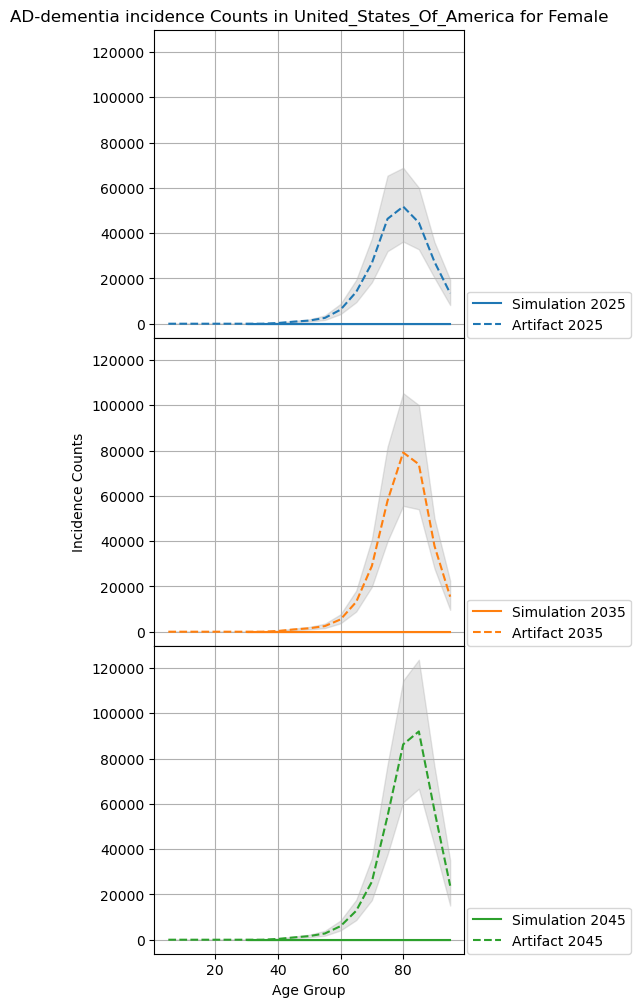

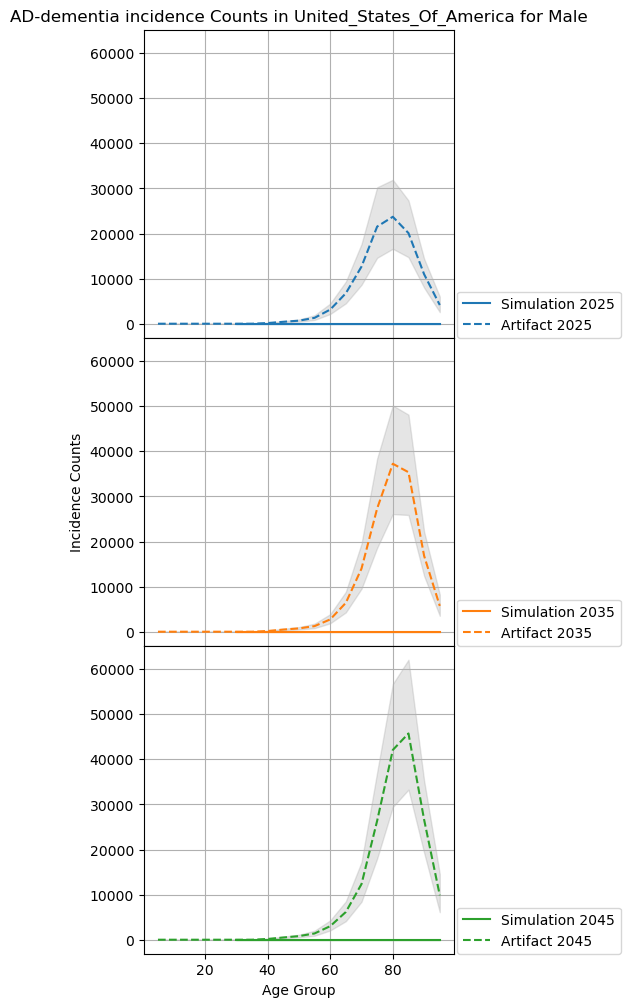

In [45]:
for location in new_sims.location.unique():
    for sex in new_sims.sex.unique():
        fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(4, 12))
        plt.subplots_adjust(hspace=0)
        for i, year in enumerate([2025, 2035, 2045]):
            color = f"C{i}"
            plot_data = new_ad_dementia_summary.query(
                "location == @location and event_year == @year and sex == @sex"
            )
            display(plot_data)

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_incidence_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()

            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            ax[i].fill_between(
                plot_data.age_start,
                plot_data["2.5%"],
                plot_data["97.5%"],
                alpha=0.2,
                color=color,
            )
            ax[i].fill_between(
                art_plot.age_start,
                art_plot["upper"],
                art_plot["lower"],
                alpha=0.2,
                color="grey",
            )
            ax[i].plot(
                plot_data.age_start,
                plot_data["mean"],
                label=f"Simulation {year}",
                color=color,
            )
            ax[i].plot(
                art_plot.age_start,
                art_plot["mean"],
                label=f"Artifact {year}",
                color=color,
                linestyle="--",
            )
            ax[i].grid(True)
            if i == 0:
                ax[i].set_title(f"AD-dementia incidence Counts in {location} for {sex}")
            #             plt.tick_params(axis='x', labelrotation=90)
            ax[i].set_xlabel("Age Group")
            if i == 1:
                ax[i].set_ylabel(f"Incidence Counts")
            ax[i].legend(loc=(1.01, 0))

#             ax[i].semilogy()

## Verifying Overall Prevalence

In [79]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("population.scaling_factor").droplevel(["year_start", "year_end"]),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_prev_data.append(df)

art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f"draw_{i}"] *= art_prev_data[f"draw_{i}_pop"]
    del art_prev_data[f"draw_{i}_pop"]
art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                  
Male   30        35      United States of America 2021       2022           0.159966   
                                                  2022       2023           0.160666   
                                                  2023       2024           0.161063   
                                                  2024       2025           0.161282   
                                                  2025       2026           0.161520   
...                                                                              ...   
Female 90        95      United States of America 2046       2047      764886.418908   
                                                  2047       2048      776180.192160   
                                                  2048       2049      788319.449677   
                                                  2049       2050      798539.193616   
                                                  2050       2051      804671.185661   

                                                                              draw_1  \
sex    age_start age_end location                 year_start year_end                  
Male   30        35      United States of America 2021       2022           0.458818   
                                                  2022       2023           0.460631   
                                                  2023       2024           0.461539   
                                                  2024       2025           0.462025   
                                                  2025       2026           0.462522   
...                                                                              ...   
Female 90        95      United States of America 2046       2047      793181.895653   
                                                  2047       2048      806347.891748   
                                                  2048       2049      820683.742797   
                                                  2049       2050      833307.201675   
                                                  2050       2051      841379.050029   

                                                                              draw_2  \
sex    age_start age_end location                 year_start year_end                  
Male   30        35      United States of America 2021       2022           0.079378   
                                                  2022       2023           0.079746   
                                                  2023       2024           0.079968   
                                                  2024       2025           0.080120   
                                                  2025       2026           0.080299   
...                                                                              ...   
Female 90        95      United States of America 2046       2047      678142.252928   
                                                  2047       2048      689451.916566   
                                                  2048       2049      702125.407716   
                                                  2049       2050      713738.403074   
                                                  2050       2051      721379.628511   

                                                                              draw_3  \
sex    age_start age_end location                 year_start year_end                  
Male   30        35      United States of America 2021       2022           0.374640   
                                                  2022       2023           0.376279   
                                                  2023       2024           0.377245   
                                                  2024       2025           0.377868   
                                                  2025       2026           0.378604   
...                        

In [80]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("person_time_alzheimers_disease_and_other_dementias")
new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_sims["total_prev"] = new_sims["value"] / new_sims["ratio"]
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = (
    new_sims.groupby([c for c in cols if c != "input_draw"])
    .describe(percentiles=[0.025, 0.975])["total_prev"]
    .reset_index()
)

new_sims = new_sims.merge(age_dictionary, on=["age_group"])
new_sims = new_sims.loc[new_sims["age_group_id"].isin(age_group_ids)]
new_sims.tail()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10934995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,3.986311
10934998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.996578


/tmp/ipykernel_1580163/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
723,2050,United_States_Of_America,85_to_89,Male,25.0,0.001339,0.000112,0.001141,0.001167,0.001332,0.001492,0.001518,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,25.0,0.001479,0.000125,0.001308,0.001308,0.001464,0.001710,0.001739,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,25.0,0.000618,0.000050,0.000520,0.000526,0.000636,0.000689,0.000704,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,25.0,0.000427,0.000067,0.000329,0.000338,0.000404,0.000568,0.000586,24,235,95 plus,95.0,125.0
727,2050,United_States_Of_America,95_plus,Male,25.0,0.000154,0.000023,0.000097,0.000111,0.000149,0.000190,0.000196,24,235,95 plus,95.0,125.0


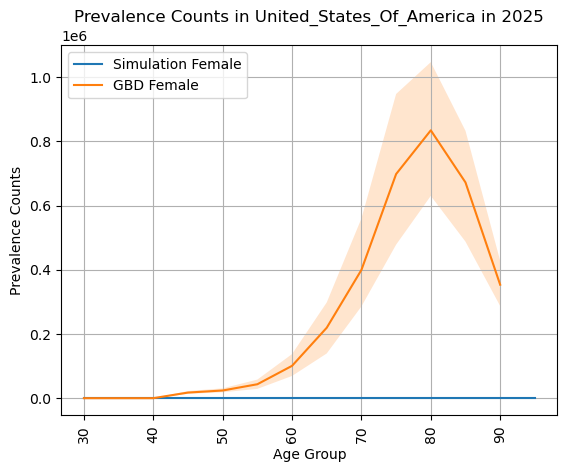

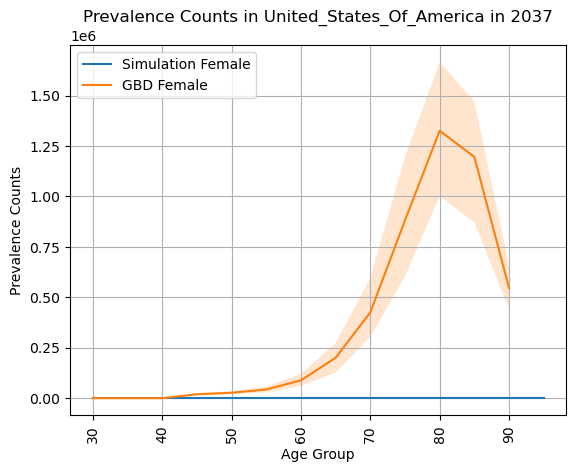

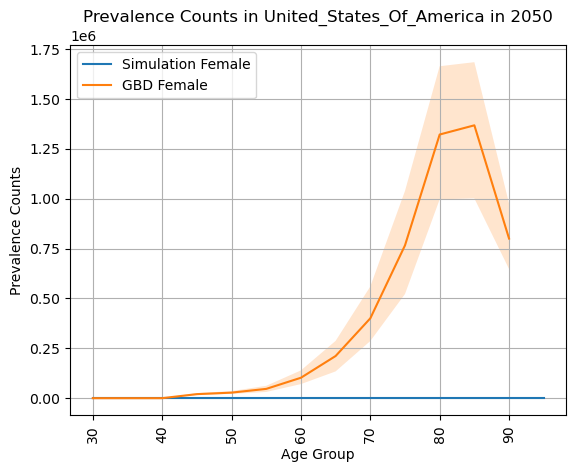

<Figure size 640x480 with 0 Axes>

In [81]:
for location in new_sims.location.unique():
    for year in [2025, 2037, 2050]:
        for sex in new_sims.sex.unique()[:1]:
            plot_data = new_sims.loc[
                (new_sims.location == location)
                & (new_sims.event_year == year)
                & (new_sims.sex == sex)
            ]
            #             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            plt.plot(plot_data.age_start, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.age_start, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.plot(art_plot.age_start, art_plot["mean"], label=f"GBD {sex}")
            plt.fill_between(
                art_plot.age_start, art_plot["upper"], art_plot["lower"], alpha=0.2
            )

            plt.title(f"Prevalence Counts in {location} in {year}")
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
            plt.grid()
        #             plt.semilogy()
        plt.figure()

# Dementia Prevalence

In [54]:
# swtich from this
# art.load(
#     'population.scaling_factor'
#         )#.droplevel(['year_start', 'year_end'])

# to this
# art.load(
#     'cause.alzheimers.prevalence'
#         )#.droplevel(['year_start', 'year_end'])

# ?

In [82]:
art_prev_data = []
for artifact_dir in artifact_dirs:
    art = Artifact(artifact_dir)
    df = pd.merge(
        art.load("cause.alzheimers.prevalence").droplevel(["year_start", "year_end"]),
        art.load("population.structure"),
        left_index=True,
        right_index=True,
        suffixes=["", "_pop"],
    )
    art_prev_data.append(df)

art_prev_data = pd.concat(art_prev_data)
for i in range(500):
    art_prev_data[f"draw_{i}"] *= art_prev_data[f"draw_{i}_pop"]
    del art_prev_data[f"draw_{i}_pop"]


art_prev_data

draw_0  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United States of America 2046       2047      55173.295736   
                                                  2047       2048      56569.197309   
                                                  2048       2049      58017.307994   
                                                  2049       2050      59455.918860   
                                                  2050       2051      60791.531100   

                                                                             draw_1  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United States of America 2046       2047      62960.360100   
                                                  2047       2048      64778.886343   
                                                  2048       2049      66721.023153   
                                                  2049       2050      68637.274127   
                                                  2050       2051      70358.671211   

                                                                             draw_2  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                             ...   
Male   95.0      125.0   United States of America 2046       2047      53415.859578   
                                                  2047       2048      54902.012715   
                                                  2048       2049      56443.222505   
                                                  2049       2050      57958.095674   
                                                  2050       2051      59376.361251   

                                                                             draw_3  \
sex    age_start age_end location                 year_start year_end                 
Female 5.0       10.0    United States of America 2021       2022          0.000000   
                                                  2022       2023          0.000000   
                                                  2023       2024          0.000000   
                                                  2024       2025          0.000000   
                                                  2025       2026          0.000000   
...                                                                     

In [56]:
# t[t.sub_entity == 'alzheimers_disease_state']

In [83]:
cols = ["input_draw", "event_year", "location", "age_group", "sex"]

new_sims = load_df("person_time_alzheimers_disease_and_other_dementias")

# restrict to dementia state only
new_sims = new_sims[new_sims.sub_entity == "alzheimers_disease_state"]

new_sims = new_sims.merge(
    scale[["location", "sex", "age_group", "ratio", "event_year"]]
)
new_sims["total_prev"] = new_sims["value"] / new_sims["ratio"]
new_sims = new_sims.groupby(cols).sum(numeric_only=True)
new_sims = (
    new_sims.groupby([c for c in cols if c != "input_draw"])
    .describe(percentiles=[0.025, 0.975])["total_prev"]
    .reset_index()
)

new_sims = new_sims.merge(age_dictionary, on=["age_group"])
new_sims = new_sims.loc[new_sims["age_group_id"].isin(age_group_ids)]
new_sims.tail()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10934995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,3.986311
10934998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.996578


/tmp/ipykernel_1580163/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,event_year,location,age_group,sex,count,mean,std,min,2.5%,50%,97.5%,max,Unnamed: 0,age_group_id,age_group_name,age_start,age_end
723,2050,United_States_Of_America,85_to_89,Male,25.0,0.000720,0.000057,0.000625,0.000637,0.000702,0.000834,0.000865,22,31,85 to 89,85.0,90.0
724,2050,United_States_Of_America,90_to_94,Female,25.0,0.000889,0.000062,0.000767,0.000800,0.000887,0.001013,0.001021,23,32,90 to 94,90.0,95.0
725,2050,United_States_Of_America,90_to_94,Male,25.0,0.000353,0.000025,0.000291,0.000306,0.000358,0.000395,0.000404,23,32,90 to 94,90.0,95.0
726,2050,United_States_Of_America,95_plus,Female,25.0,0.000264,0.000041,0.000200,0.000213,0.000256,0.000352,0.000358,24,235,95 plus,95.0,125.0
727,2050,United_States_Of_America,95_plus,Male,25.0,0.000092,0.000014,0.000065,0.000070,0.000092,0.000116,0.000122,24,235,95 plus,95.0,125.0


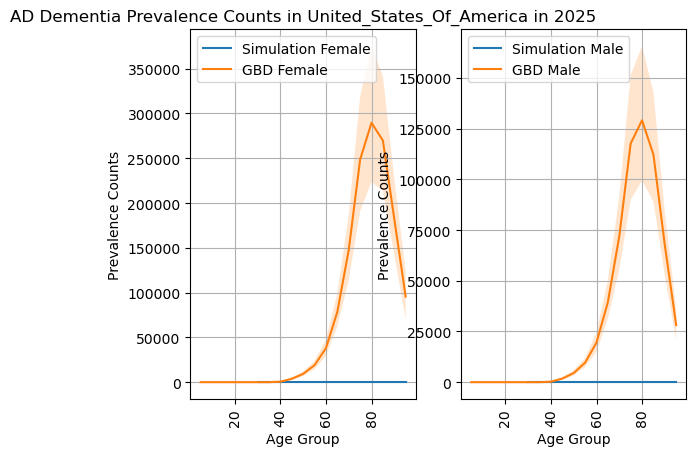

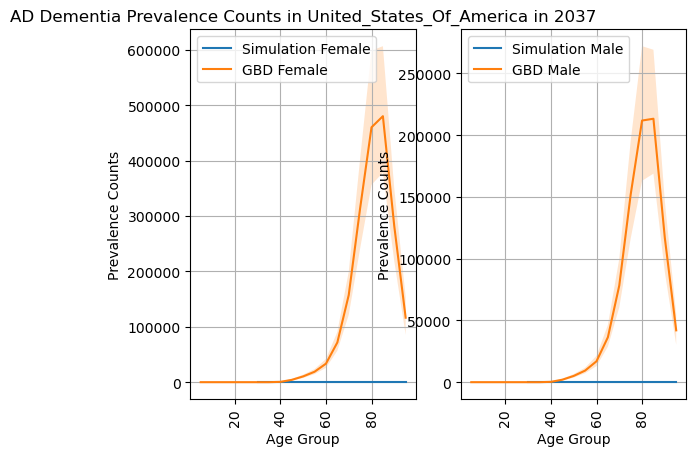

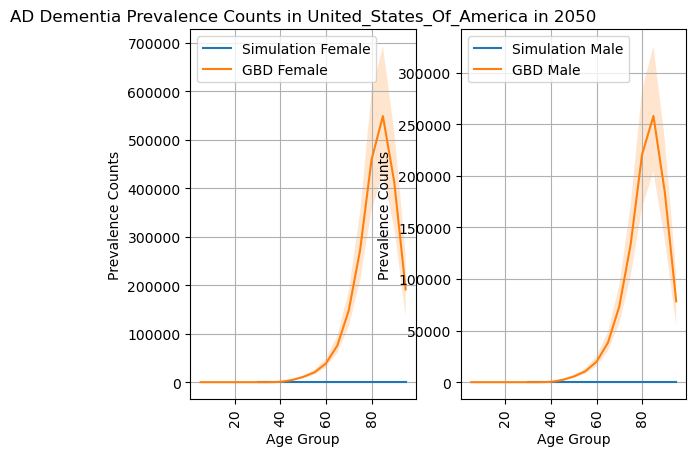

<Figure size 640x480 with 0 Axes>

In [84]:
for location in new_sims.location.unique():
    for year in [2025, 2037, 2050]:
        for i, sex in enumerate(new_sims.sex.unique()):
            plt.subplot(1, 2, i + 1)
            plot_data = new_sims.loc[
                (new_sims.location == location)
                & (new_sims.event_year == year)
                & (new_sims.sex == sex)
            ]
            #             gbd_plot = gbd_data.loc[(gbd_data.location_name == location) & (gbd_data.sex == sex) & (gbd_data.measure == 'prevalence')]

            location_w_spaces = location.replace("_", " ").replace("Of", "of")
            art_plot = art_prev_data.query(
                f'location == "{location_w_spaces}" and year_start == {year} and sex == "{sex}"'
            ).reset_index()
            art_plot["mean"] = art_plot.filter(like="draw_").mean(axis=1)
            art_plot["upper"] = np.percentile(
                art_plot.filter(like="draw_"), 97.5, axis=1
            )
            art_plot["lower"] = np.percentile(
                art_plot.filter(like="draw_"), 2.5, axis=1
            )

            plt.plot(plot_data.age_start, plot_data["mean"], label=f"Simulation {sex}")
            plt.fill_between(
                plot_data.age_start, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
            )

            plt.plot(art_plot.age_start, art_plot["mean"], label=f"GBD {sex}")
            plt.fill_between(
                art_plot.age_start, art_plot["upper"], art_plot["lower"], alpha=0.2
            )

            if i == 0:
                plt.title(f"AD Dementia Prevalence Counts in {location} in {year}")
            plt.tick_params(axis="x", labelrotation=90)
            plt.xlabel("Age Group")
            plt.ylabel(f"Prevalence Counts")
            plt.legend()
            plt.grid()
        #             plt.semilogy()
        plt.figure()

## Total Sim Population Over Time

In [85]:
cols = ["input_draw", "event_year", "location"]  # , 'age_group']

person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10934995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,3.986311
10934998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.996578


/tmp/ipykernel_1580163/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()


,event_year,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,United_States_Of_America,25.0,101521.229405,150.225996,101161.106092,101222.694593,101562.228611,101732.743053,101772.506502
1,2026,United_States_Of_America,25.0,108627.426256,773.597440,106855.052704,107007.828063,108873.122519,109509.836003,109538.836413
2,2027,United_States_Of_America,25.0,115423.647584,1335.380194,112643.175907,112783.394387,115878.565366,117005.894045,117052.533881
3,2028,United_States_Of_America,25.0,121939.770787,1890.293001,118167.704312,118236.767146,122486.373717,124554.571389,124584.169747
4,2029,United_States_Of_America,25.0,128192.000219,2362.452380,123455.047228,123689.741273,128946.688569,131403.053251,131606.056126
5,2030,United_States_Of_America,25.0,134285.574483,2862.945113,128332.298426,129026.813415,134975.485284,138352.289117,138578.611910
6,2031,United_States_Of_America,25.0,140211.404791,3307.181073,133262.866530,134264.726078,140846.822724,145064.239836,145220.303901
7,2032,United_States_Of_America,25.0,145797.840602,3791.143337,138099.258042,139307.409172,146265.713895,151491.169336,151747.389459
8,2033,United_States_Of_America,25.0,151020.744805,4183.521224,142841.971253,144024.410678,151524.654346,157545.677755,157574.379192
9,2034,United_States_Of_America,25.0,155855.661383,4507.533289,147349.492129,148490.972211,156041.642710,162922.613005,163068.511978


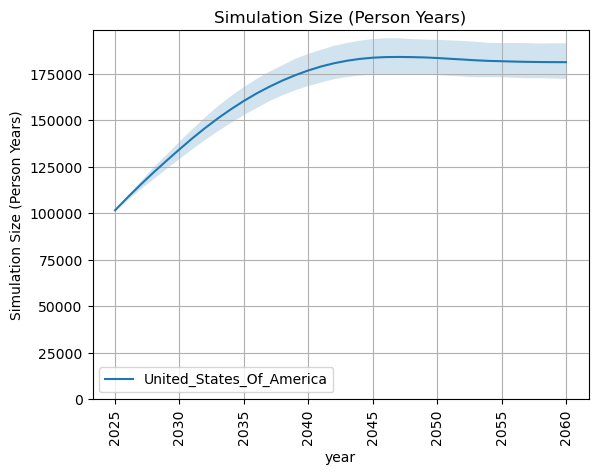

In [86]:
for location in person_time_total.location.unique():
    plot_data = person_time_total.loc[(person_time_total.location == location)]
    plt.plot(plot_data.event_year, plot_data["mean"], label=location)
    plt.fill_between(
        plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
    )
    plt.title(f"Simulation Size (Person Years)")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()

# Decompose person-time by state

In [87]:
cols = ["input_draw", "event_year", "sub_entity", "location"]  # , 'age_group']

person_time_total = load_df("person_time_alzheimers_disease_and_other_dementias")
person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
person_time_total = (
    person_time_total.groupby([c for c in cols if c != "input_draw"])["value"]
    .describe(percentiles=[0.025, 0.975])
    .reset_index()
)
person_time_total  # .head()

,measure,entity_type,entity,sub_entity,age_group,event_year,sex,treatment,artifact_path,input_draw_number,scenario,input_draw,random_seed,value
0,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,susceptible_to_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
1,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waiting_for_treatment,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
2,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
3,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,full_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
4,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_blood_based_biomarker_state,25_to_29,2025,Female,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,158,baseline,158,2284,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10934995,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934996,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,waning_effect_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.000000
10934997,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_long,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,3.986311
10934998,person_time,cause,alzheimers_disease_and_other_dementias,alzheimers_disease_state,95_plus,2060,Male,no_effect_after_short,/homes/abie/projects/2025/vivarium_csu_alzheim...,356,bbbm_testing_and_treatment,356,2284,0.996578


/tmp/ipykernel_1580163/3190831669.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  temp = temp.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_1580163/4293227660.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total = person_time_total.groupby(cols)["value"].sum().reset_index()
/tmp/ipykernel_1580163/4293227660.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  person_time_total.groupby([c 

,event_year,sub_entity,location,count,mean,std,min,2.5%,50%,97.5%,max
0,2025,alzheimers_blood_based_biomarker_state,United_States_Of_America,25.0,45876.536947,778.684933,43781.152635,44151.281588,45916.818617,47164.035592,47291.099247
1,2025,alzheimers_disease_state,United_States_Of_America,25.0,32979.765311,682.360095,31424.585900,31715.187953,33017.615332,34380.136345,34555.334702
2,2025,alzheimers_mild_cognitive_impairment_state,United_States_Of_America,25.0,22664.927146,215.238966,22304.405202,22325.632307,22651.712526,23141.929090,23269.590691
3,2026,alzheimers_blood_based_biomarker_state,United_States_Of_America,25.0,44523.782396,1015.830318,41966.882957,42359.733881,44538.053388,46131.780424,46405.639973
4,2026,alzheimers_disease_state,United_States_Of_America,25.0,38639.668830,858.897880,37170.852841,37226.760849,38570.546201,40273.697467,41022.625599
...,...,...,...,...,...,...,...,...,...,...,...
103,2059,alzheimers_disease_state,United_States_Of_America,25.0,97080.240055,2913.389447,89996.944559,91492.708008,96863.364819,101637.171253,102776.558522
104,2059,alzheimers_mild_cognitive_impairment_state,United_States_Of_America,25.0,36526.545435,1740.040031,33723.192334,33796.141821,36474.245038,39138.296509,39199.885010
105,2060,alzheimers_blood_based_biomarker_state,United_States_Of_America,25.0,47529.640082,3151.788067,41007.676934,41775.141410,47787.394935,51964.948939,52300.396988
106,2060,alzheimers_disease_state,United_States_Of_America,25.0,97118.169802,2903.620131,89922.699521,91606.517180,96936.114990,101728.358111,102719.753593


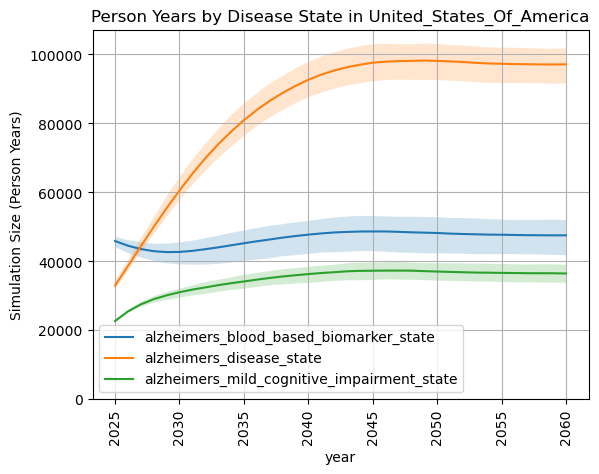

In [88]:
for location in person_time_total.location.unique():
    for sub_entity in person_time_total.sub_entity.unique():
        plot_data = person_time_total.query(
            "location == @location and sub_entity == @sub_entity"
        )
        plt.plot(plot_data.event_year, plot_data["mean"], label=sub_entity)
        plt.fill_between(
            plot_data.event_year, plot_data["2.5%"], plot_data["97.5%"], alpha=0.2
        )
    plt.title(f"Person Years by Disease State in {location}")
    plt.tick_params(axis="x", labelrotation=90)
    plt.xlabel("year")
    plt.ylabel("Simulation Size (Person Years)")
    plt.legend()
    plt.axis(ymin=0)
    plt.grid()

# Did the fix to initialization work?  Seems so